In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load dataset
df = pd.read_parquet('../data/cleaned_data_snappy.parquet')

In [3]:
# Log-transform target variable if right-skewed
df['totalFare'] = np.log1p(df['totalFare'])

In [4]:
# Define features and target
X = df.drop('totalFare', axis=1)  # Features
y = df['totalFare']               # Target variable

In [5]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [6]:
# Ensure all categorical columns are strings
for col in categorical_cols:
    X[col] = X[col].astype(str)  # Convert to string to avoid unhashable errors
    X[col + "_freq"] = X.groupby(col)[col].transform("count")

# Drop original categorical columns
X.drop(columns=categorical_cols, inplace=True)


In [7]:
# Convert any remaining non-numeric columns to numeric codes**
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_cols:
    X[col] = X[col].astype("category").cat.codes  # Convert categorical variables to numeric codes


In [8]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [9]:
# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)


In [10]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [20, 50, 100],  # Smaller for speed
    'max_depth': [10, 20],      
    'min_samples_split': [5, 10], 
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt']  # Speed boost
}

In [11]:
# Use RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_grid,
    n_iter=5, cv=2, scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=1, random_state=42
)

In [12]:
# Train on a **subset** of training data for speed
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)


In [13]:
random_search.fit(X_sample, y_sample)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 5],
                                        'min_samples_split': [5, 10],
                                        'n_estimators': [20, 50, 100]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [14]:
# Best model
best_rf = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

✅ Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}


In [15]:
# Train best model on full dataset
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=50, random_state=42)

In [16]:
# Evaluate on validation set
y_val_pred = best_rf.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f'Validation MSE: {val_mse}')
print(f'Validation MAE: {val_mae}')


Validation MSE: 0.00044907252620237086
Validation MAE: 0.010976204876678225


In [17]:
# Evaluate on test set
y_test_pred = best_rf.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')

Test MSE: 0.0004428649288428195
Test MAE: 0.011004084191883182


In [18]:
# Given MSE and MAE in log-space
validation_mse_log = val_mse
test_mse_log = test_mse

validation_mae_log = val_mae
test_mae_log = test_mae

In [19]:
# Convert MSE back to real scale (square root first for RMSE, then apply expm1)
validation_rmse_real = np.expm1(np.sqrt(validation_mse_log))
test_rmse_real = np.expm1(np.sqrt(test_mse_log))

In [20]:
# Convert MAE back to real scale
validation_mae_real = np.expm1(validation_mae_log)
test_mae_real = np.expm1(test_mae_log)

In [21]:
# Print results
print(f"Validation RMSE (real currency): ${validation_rmse_real:.4f}")
print(f"Test RMSE (real currency): ${test_rmse_real:.4f}")

Validation RMSE (real currency): $0.0214
Test RMSE (real currency): $0.0213


In [23]:
import matplotlib.pyplot as plt

#Get feature importance from trained model
feature_importance = best_rf.feature_importances_

In [24]:
#Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

In [25]:
#Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)


In [28]:
#Display top features
print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

Top 10 Most Important Features:
                    Feature  Importance
26                fareLag_1    0.341008
11             pricePerMile    0.172602
27      fare_rolling_avg_30    0.100002
24             totalAirtime    0.083427
4       totalTravelDistance    0.081000
28  destinationAirport_freq    0.036947
5     travelDurationMinutes    0.033443
29       fareBasisCode_freq    0.028753
0            isBasicEconomy    0.019277
31         mainAirline_freq    0.014377


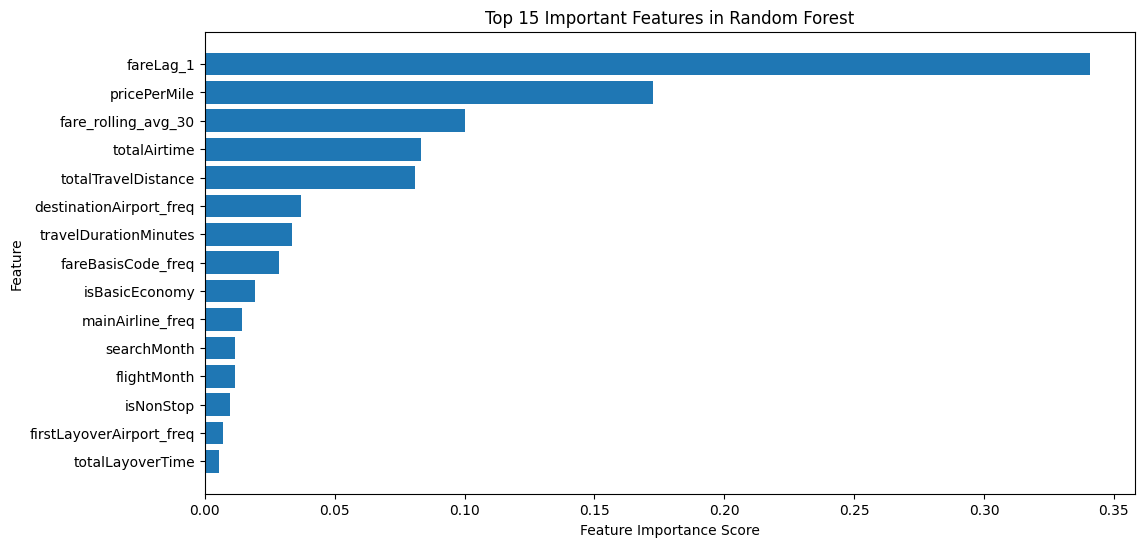

In [27]:
#Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df["Feature"][:15], feature_importance_df["Importance"][:15])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 15 Important Features in Random Forest")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()